### 0 数据探索

首先，我们对数据集进行快速浏览和查看，以对我们数据分析的对象有大致的“感观”。

In [1]:
# 加载函数库
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

# 显示配置
%matplotlib inline
plt.rcParams['font.family']=['SimHei'] #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

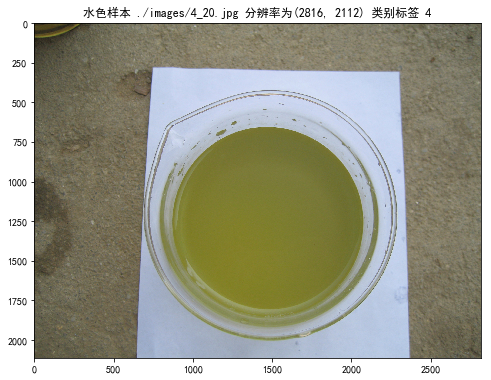

In [2]:
# 加载数据
imgFile = "./images/4_20.jpg"
img = Image.open(imgFile)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title('水色样本 '+imgFile+' 分辨率为'+str(img.size)+" 类别标签 "+str(imgFile[9]))
plt.show()

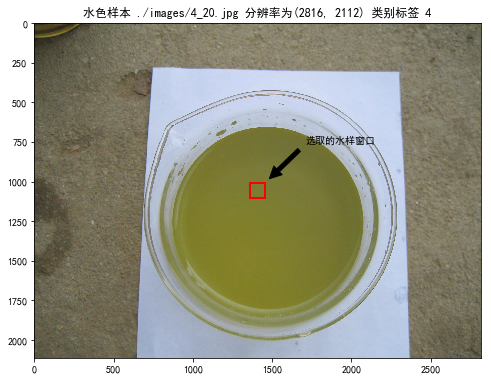

In [3]:
# 我们需要选取仅包括水样的图像部分来进行分析
size = 100
cx, cy = (int(i/2) for i in img.size)

plt.figure(figsize=(8,8))
plt.imshow(img)

plt.plot([cx-50, cx+50], [cy+50, cy+50], 'r', linewidth=2)
plt.plot([cx+50, cx+50], [cy-50, cy+50], 'r', linewidth=2)
plt.plot([cx-50, cx+50], [cy-50, cy-50], 'r', linewidth=2)
plt.plot([cx-50, cx-50], [cy-50, cy+50], 'r', linewidth=2)
plt.annotate('选取的水样窗口', xy=(cx+50,cy-50), xytext=(cx+300, cy-300),
            arrowprops=dict(facecolor='black', shrink=0.1))

plt.title('水色样本 '+imgFile+' 分辨率为'+str(img.size)+" 类别标签 "+str(imgFile[9]))
plt.show()

看起来对于基于典型机器学习的分类模型来说，100x100的图像将提供10000个特征用于建模 - 特征数量无疑是够用了，甚至远远超过数据样本的数量。这意味着模型可能存在过拟合的风险。后续我们做分析的时候需要注意！

除此以外，我们可能还要关注另外一些问题：
- 是否存在一些尺寸特别小的图像，找出选取的水样窗口出错？
- 是否选取的水样窗口一定不会包括“非水样”部分？

上述两个问题其实是相关的，也就是我们需要快速的对图像数据进行分析，看看选取水样窗口的方式是否会造成有偏差的数据？我们可以进一步对数据进行检查；比如:
- 查看全体图像数据的尺寸分布
- 查看选取的水样窗口的像素值标准差（二阶）

In [4]:
# 加载图像统计信息模块（注：也可以直接通过颜色通道来计算）
from PIL import ImageStat 

# 遍历全体图像进行快速检查
size = 100
imgPath = './images'
imgWidth = []       # 图像宽度
imgHeight = []      # 图像高度
imgRrange = []      # 图像红色通道极差
imgGrange = []      # 图像绿色通道极差
imgBrange = []      # 图像蓝色通道极差

newImgs = []        # 获得选取后的图像作为模型训练和验证数据

imgFiles = os.listdir(imgPath)
for imgFile in imgFiles:
    img = Image.open(os.path.join(imgPath,imgFile))
    imgWidth.append(img.size[0])
    imgHeight.append(img.size[1])
    
    # 获得图像中心区域大小为size的图像块
    cx, cy = (int(i/2) for i in img.size)
    box = (cx-50, cy-50, cx+50, cy+50)
    region = img.crop(box)
    
    # 计算选取图像块的标准差
    stat = ImageStat.Stat(region)
    imgRrange.append(stat.extrema[0][1]-stat.extrema[0][0])
    imgGrange.append(stat.extrema[1][1]-stat.extrema[1][0])
    imgBrange.append(stat.extrema[2][1]-stat.extrema[2][0])
    
    newImgs.append(region)

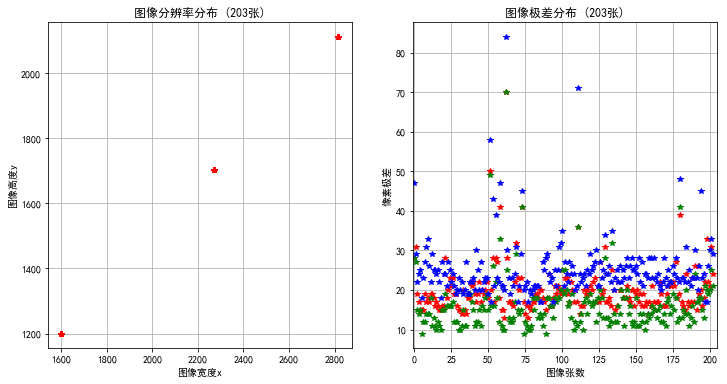

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(imgWidth, imgHeight, 'r*')
plt.grid()
plt.xlabel('图像宽度x')
plt.ylabel('图像高度y')
plt.title('图像分辨率分布 ('+str(len(imgFiles))+'张)')

plt.subplot(122)
plt.plot(imgRrange,'r*')
plt.plot(imgGrange,'g*')
plt.plot(imgBrange,'b*')
plt.grid()
plt.xlabel('图像张数')
plt.ylabel('像素极差')
plt.xlim([-1, 205])
plt.title('图像极差分布 ('+str(len(imgFiles))+'张)')
plt.show()

<hr>

有两张图像的极差分布看起来需要关注；所以我们把这两张图像特别挑出来检查一下

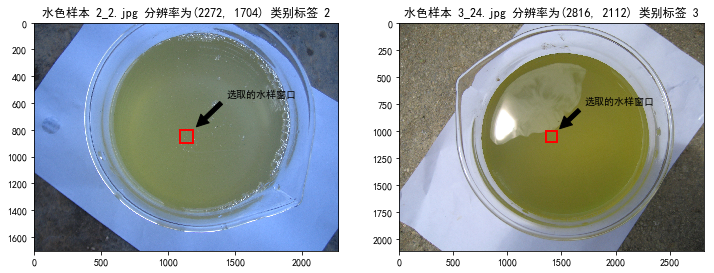

In [6]:
# 关注可能的异常数据
plt.figure(figsize=(12,6))

iB = np.array(imgBrange)
nFiles = np.where(iB>65)[0]
for i, j in enumerate(nFiles):
    imgFile = imgFiles[j]
    img = Image.open(os.path.join(imgPath,imgFile))

    plt.subplot(1,len(nFiles),i+1)
    plt.imshow(img)
    
    cx, cy = (int(i/2) for i in img.size)
    plt.plot([cx-50, cx+50], [cy+50, cy+50], 'r', linewidth=2)
    plt.plot([cx+50, cx+50], [cy-50, cy+50], 'r', linewidth=2)
    plt.plot([cx-50, cx+50], [cy-50, cy-50], 'r', linewidth=2)
    plt.plot([cx-50, cx-50], [cy-50, cy+50], 'r', linewidth=2)
    plt.annotate('选取的水样窗口', xy=(cx+50,cy-50), xytext=(cx+300, cy-300),
            arrowprops=dict(facecolor='black', shrink=0.1))

    plt.title('水色样本 '+imgFile+' 分辨率为'+str(img.size)+" 类别标签 "+str(imgFile[0]))

plt.show()

<hr>

目前看起来不算太糟糕，但是如果选取的窗口大小或者位置发生变化，或者模型效果不好，可能都需要我们回过头来对数据进行更仔细的预处理！

然后随机挑选一些选取的水样图像进行预览

In [23]:
rc

array([ 50,  29, 133,  11, 191, 175, 119,  39, 109])

[152 113  29  83  47 175 114 176 161]   0   152
[152 113  29  83  47 175 114 176 161]   1   113
[152 113  29  83  47 175 114 176 161]   2   29
[152 113  29  83  47 175 114 176 161]   3   83
[152 113  29  83  47 175 114 176 161]   4   47
[152 113  29  83  47 175 114 176 161]   5   175
[152 113  29  83  47 175 114 176 161]   6   114
[152 113  29  83  47 175 114 176 161]   7   176
[152 113  29  83  47 175 114 176 161]   8   161


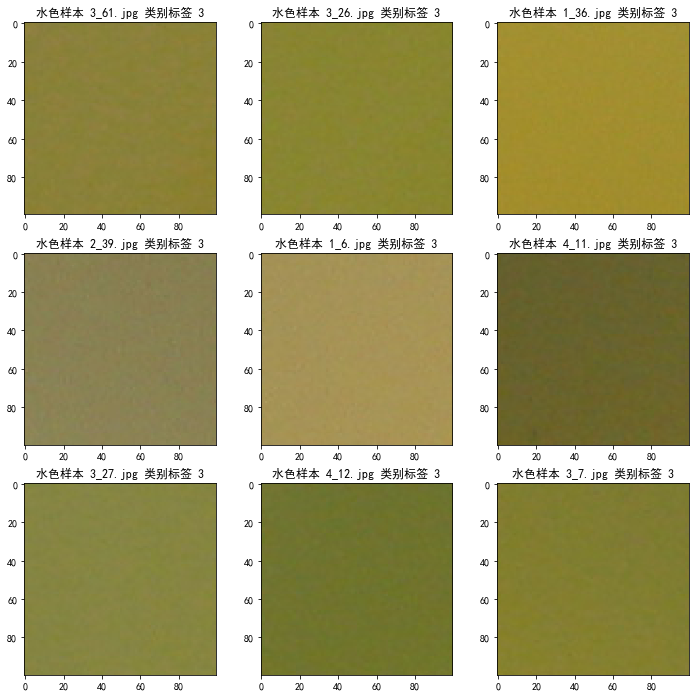

In [7]:
from numpy import random
rc = random.choice(np.arange(len(newImgs)),9)

plt.figure(figsize=(12,12))
for i, j in enumerate(rc):
    print(rc," ",i," ",j)
    plt.subplot(3,3,i+1)
    plt.imshow(newImgs[j])
    plt.title('水色样本 '+imgFiles[j]+" 类别标签 "+str(imgFile[0]))
plt.show()

### 1. 数据预处理

到目前为止，其实我们已经完成了
- 数据清洗（排除异常或错误数据）
- 数据集成（本案例无需集成）

对于**数据规约**这一步，我们需要实现的是
1. 选取100x100的水样图像，减少特征数量
2. 基于水样图像进一步构建特征；也就是一阶矩，二阶矩和三阶矩

最后在**数据变换**这一步，我们需要实现的是
- 数据规范化/归一化

In [8]:
# 构建训练数据集和分类标签
data = []
dy = []
for i, img in enumerate(newImgs):
    r, g, b = np.split(np.array(img), 3, axis = 2)
    
    #计算一阶矩
    r_m1 = np.mean(r)
    g_m1 = np.mean(g)
    b_m1 = np.mean(b)
    
    #二阶矩
    r_m2 = np.std(r)
    g_m2 = np.std(g)
    b_m2 = np.std(b)
    
    #三阶矩
    r_m3 = np.mean(abs(r - r.mean())**3)**(1/3)
    g_m3 = np.mean(abs(g - g.mean())**3)**(1/3)
    b_m3 = np.mean(abs(b - b.mean())**3)**(1/3)
    
    # 构造新数据集
    df = np.array([r_m1,g_m1,b_m1,r_m2,g_m2,b_m2,r_m3,g_m3,b_m3])
    data.append(df)
    
    # 保存对应的分类标签
    dy.append(int(imgFiles[i][0]))

dy = np.array(dy)
data = pd.DataFrame(np.array(data))
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 9 columns):
0    203 non-null float64
1    203 non-null float64
2    203 non-null float64
3    203 non-null float64
4    203 non-null float64
5    203 non-null float64
6    203 non-null float64
7    203 non-null float64
8    203 non-null float64
dtypes: float64(9)
memory usage: 14.4 KB


,0,1,2,3,4,5,6,7,8
0,148.6037,138.6396,64.3687,3.633077,4.128330,10.499046,4.254340,4.802914,12.057685
1,163.6769,145.5470,54.4608,3.934350,2.840174,3.502551,4.453499,3.245141,4.065518
2,153.9430,147.0834,71.9601,2.225657,1.810979,3.136608,2.644340,2.148726,3.651915
3,150.3724,151.3982,64.3164,2.037380,1.521590,2.728093,2.375780,1.819692,3.173392
4,150.7381,150.9774,64.6204,1.918674,1.665260,3.110901,2.259915,1.958815,3.619921


In [9]:
# 数据变换 - 采用L2-Norm/Z-score
# dataNorm = pd.DataFrame(preprocessing.normalize(data,norm='l2'))
dataNorm = (data - data.mean(axis=0))/(data.std(axis=0))
dataNorm.head()

,0,1,2,3,4,5,6,7,8
0,0.656137,0.303074,0.094246,1.369340,2.881755,6.693904,1.365634,2.720959,5.729997
1,1.554429,0.875369,-0.476044,1.732253,1.222422,0.276967,1.573050,1.060575,0.181087
2,0.974334,1.002664,0.531199,-0.326034,-0.103332,-0.058663,-0.311123,-0.108060,-0.106075
3,0.761543,1.360156,0.091235,-0.552833,-0.476107,-0.433338,-0.590819,-0.458768,-0.438310
4,0.783337,1.325292,0.108733,-0.695827,-0.291040,-0.082240,-0.711488,-0.310481,-0.128289


In [10]:
# 样本对应的分类标签
dy

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5])

### 2. 建模分析和性能评估

采用支持向量机(svm)来创建分类模型，将水样分为5个不同的类别；并评估模型的性能

In [11]:
# 分割数据为训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataNorm, dy, test_size=0.2, stratify=dy, random_state=2020)

In [12]:
# 导入svm分类模型并训练
from sklearn import svm

model = svm.SVC(C=200, gamma='auto')   # 特别注意C值的选取
model.fit(X_train, y_train)
print("SVM模型在训练集上的准确率为", round(model.score(X_train, y_train),3))

SVM模型在训练集上的准确率为 1.0


In [13]:
# 评估模型在测试集上性能
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = model.predict(X_test)
print("SVM模型在测试集上的准确率为", round(accuracy_score(y_test, y_pred),3))
print("SVM模型在测试集上的混淆矩阵为\n",confusion_matrix(y_test, y_pred))

SVM模型在测试集上的准确率为 0.927
SVM模型在测试集上的混淆矩阵为
 [[ 9  0  1  0  0]
 [ 0  9  0  0  0]
 [ 1  0 14  1  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  1]]


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label')
    plt.xlabel('Prediction')
    plt.tight_layout()

Confusion matrix, without normalization


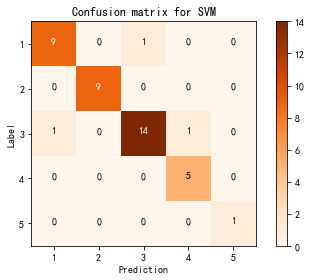

In [15]:
# 进一步可视化混淆矩阵
import itertools
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["1","2","3","4","5"],title='Confusion matrix for SVM',cmap=plt.cm.Oranges)

此外，我们对分类模型的性能评估一个更常见的指标是AUC值；另外，ROC曲线也非常常见。但是，这些指标一般用于评估**二分类模型**的性能！

### 4. 尝试更多模型，提升性能 

我们可以试试更多的分类算法，看看能否提升分类性能；比如
- 神经网络(NN)模型 
- 卷积神经网络(CNN)模型

#### 4.1 神经网络(NN)模型 

采用3个隐藏层，每层50个神经元的基本架构

In [16]:
from sklearn.neural_network import MLPClassifier  

mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=5000, random_state=2020, activation="relu", solver="adam")  
mlp.fit(X_train, y_train)
print("神经网络模型在训练集上的分类准确率: %.2f" % mlp.score(X_train, y_train))

神经网络模型在训练集上的分类准确率: 1.00


In [17]:
y_pred = mlp.predict(X_test)
print("SVM模型在测试集上的准确率为", round(accuracy_score(y_test, y_pred),3))
print("SVM模型在测试集上的混淆矩阵为\n",confusion_matrix(y_test, y_pred))

SVM模型在测试集上的准确率为 0.951
SVM模型在测试集上的混淆矩阵为
 [[ 8  0  2  0  0]
 [ 0  9  0  0  0]
 [ 0  0 16  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  1]]


Confusion matrix, without normalization


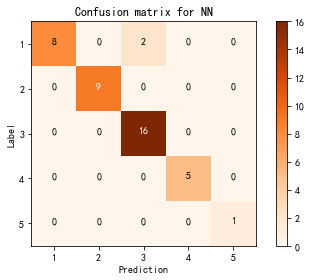

In [18]:
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["1","2","3","4","5"],title='Confusion matrix for NN',cmap=plt.cm.Oranges)

#### 4.2 卷积神经网络(CNN)模型

这一部分作为第八次作业布置给各位同学！你的作业得分就是提交的CNN模型在测试集上的准确率×100；也就是如果准确率是0.92，本次作业得分为92分。

特别提示1：
- 本次作业可选哟！也就是不提交作业也不影响各位的期末总成绩，但是完成的话，有额外（**生命值**）加持...

特别提示2：
1. 需要采用整张或者部分图像作为模型输入，而不是上面构建的9个颜色矩特征！
2. 建议采用Keras/Pytorch构建CNN；
3. （Bonus+20) 思考一下：有没有可能结合彩色图像和人工构建的颜色矩特征来联合建模？

**提交要求**：
- 必须用Jupyter Notebook完成，保存为ipynb格式提交
- 提交文件名为“Python数据分析第8次作业+班级+姓名.ipynb” （注：请规范文件名）
- 提交到刘顿同学的邮箱 810792334@qq.com
- 提交的截止时间为2019年4月30日下午17:00

In [23]:
import keras
from keras.preprocessing.image import img_to_array#图片转为array
from keras.utils import to_categorical#相当于one-hot
from sklearn.model_selection import train_test_split
import numpy as np
import random
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
import keras.backend as K

Epoch 1/30
5/5 [==============================] - 6s 1s/step - loss: 1.5123 - acc: 0.3625 - val_loss: 1.3502 - val_acc: 0.3810
Epoch 2/30
5/5 [==============================] - 4s 854ms/step - loss: 1.4429 - acc: 0.3823 - val_loss: 1.2962 - val_acc: 0.3333
Epoch 3/30
5/5 [==============================] - 4s 847ms/step - loss: 1.1838 - acc: 0.5197 - val_loss: 1.0333 - val_acc: 0.5714
Epoch 4/30
5/5 [==============================] - 4s 860ms/step - loss: 1.1017 - acc: 0.5355 - val_loss: 0.8154 - val_acc: 0.6190
Epoch 5/30
5/5 [==============================] - 4s 862ms/step - loss: 1.1305 - acc: 0.5403 - val_loss: 1.1450 - val_acc: 0.4762
Epoch 6/30
5/5 [==============================] - 4s 839ms/step - loss: 0.9367 - acc: 0.5916 - val_loss: 0.7559 - val_acc: 0.6190
Epoch 7/30
5/5 [==============================] - 5s 912ms/step - loss: 1.0942 - acc: 0.5687 - val_loss: 0.9525 - val_acc: 0.6190
Epoch 8/30
5/5 [==============================] - 4s 854ms/step - loss: 0.9294 - acc: 0.5916 

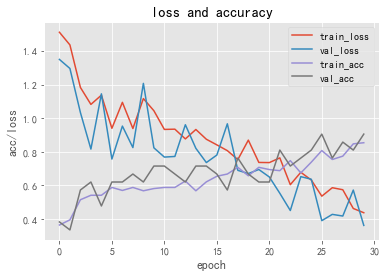

In [29]:

def cnn(channel,height,width,classes):
    input_shape = (channel,height,width)
    if K.image_data_format() == "channels_last":
        input_shape = (height,width,channel)
    model = Sequential()
    model.add(Conv2D(32,(5,5),padding="same",activation="relu",input_shape=input_shape,name="conv1"))
    model.add(Conv2D(32,(5,5),padding="same",activation="relu",name="conv2"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool1"))
    
    model.add(Conv2D(64,(3,3),padding="same",activation="relu",name="conv3"))
    model.add(Conv2D(64,(3,3),padding="same",activation="relu",name="conv4"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool2"))

    # 全连接层,展开操作，
    model.add(Flatten())
    model.add(Dense(256,activation="relu",name="fc1"))
    model.add(Dense(classes,activation="softmax",name="fc2"))
    return model

def train(aug, model,train_x,train_y,test_x,test_y):
    model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

    _history = model.fit_generator(aug.flow(train_x,train_y,batch_size=batch_size),
                        validation_data=(test_x,test_y),steps_per_epoch=len(train_x)//batch_size,
                        epochs=epochs,verbose=1)

    plt.style.use("ggplot")#matplotlib的美化样式
    plt.figure()
    N = epochs
    plt.plot(np.arange(0,N),_history.history["loss"],label ="train_loss")#model的history有四个属性，loss,val_loss,acc,val_acc
    plt.plot(np.arange(0,N),_history.history["val_loss"],label="val_loss")
    plt.plot(np.arange(0,N),_history.history["acc"],label="train_acc")
    plt.plot(np.arange(0,N),_history.history["val_acc"],label="val_acc")
    plt.title("loss and accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc/loss")
    plt.legend(loc="best")
#     plt.savefig("../result/result.png")
    plt.show()

if __name__ =="__main__":
   
    #模型参数设置
    channel = 3
    height = 100
    width = 100
    class_num = 6
    norm_size = 32#参数
    batch_size = 32
    epochs = 30
    
     #拆分数据集
    data=np.array([img_to_array(img) for img in newImgs])/255
    label=np.array(dy)
    label = to_categorical(dy)
    train_x,test_x, train_y,test_y = train_test_split(data,label,test_size=0.1,random_state=0)
    #构建模型
    model = cnn(channel=channel, height=height,width=width, classes=class_num)

    aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,
                       horizontal_flip=True,fill_mode="nearest")#数据增强，生成迭代器

    train(aug,model,train_x,train_y,test_x,test_y)#训练


In [86]:
help(to_categorical)

Help on function to_categorical in module keras.utils.np_utils:

to_categorical(y, num_classes=None, dtype='float32')
    Converts a class vector (integers) to binary class matrix.
    
    E.g. for use with categorical_crossentropy.
    
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.

